<a href="https://colab.research.google.com/github/GabeMaldonado/JupyterNotebooks/blob/master/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMAX

The statsmodels implementation of SARIMA is called SARIMAX, the 'X' at the end of the functions tells us that it also suppports exogenous regressor variables. 
Exogenous variables are outside information not historical label data. These exogenous labels can be related to the labels/data but they are not the actual label. We can think of them as categorical variables which can be quantified to be included in the analysis. To quantify these variables, we can use techniques such as one-hot encoding and/or dummy variables (pd.get_dummies()). Once we have a solid idea of the problem that we wish to solve and of the data that we are working with, SARIMAX makes it easy to create aditional columns as exogenous variables. 



In [0]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline

In [0]:
# ignore errors
import warnings
warnings.filterwarnings('ignore')

## Load Data
For this notebook, we will work with the Restaurant Visitors Daset

In [0]:
# load data to df

df = pd.read_csv('RestaurantVisitors.csv', index_col = 'date', parse_dates = True)

In [4]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [0]:
# Set frequency, this is daily data so set the frequency to 'D'

df.index.freq = 'D'

This data set contains the number of patrons for 4 restaurants, a holiday column which indicates whether it was a holiday or not and the name of the holyday so we will see how the exogenous variables (holiday) affects the number of patrons going to a restaurant.
We will first perform the normal SARIMA model and then run a SARIMAX to compare. 

In [6]:
# check tail of df

df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


We see lots of NaN so we would need to drop these as we cannot use them for training.

In [0]:
# create a new df (df1) with non-nan values

df1 = df.dropna()

In [8]:
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


Notice that the nuber of customers per restaurants are floating point values. Change the data type of these values to integers.

In [9]:
df1.columns

Index(['weekday', 'holiday', 'holiday_name', 'rest1', 'rest2', 'rest3',
       'rest4', 'total'],
      dtype='object')

In [0]:
cols = ['rest1', 'rest2', 'rest3', 'rest4', 'total']

In [0]:
for column in cols:
  df1[column] = df1[column].astype(int)

In [12]:
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


Visualize Data


---



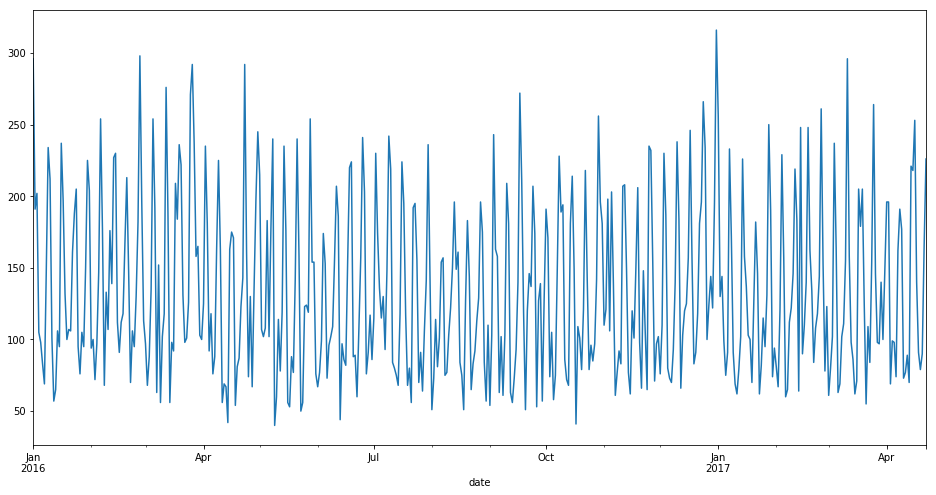

In [13]:
# plot the number of total visitors
df1['total'].plot(figsize = (16,8));

To visualize and understand these data better, we can overlap the holidays by extracting the dates that are holidays and drawing a vertical line.

In [14]:
# get holidays
# df1.query('holiday==1').index --> or in pandas

df1[df1['holiday']==1].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

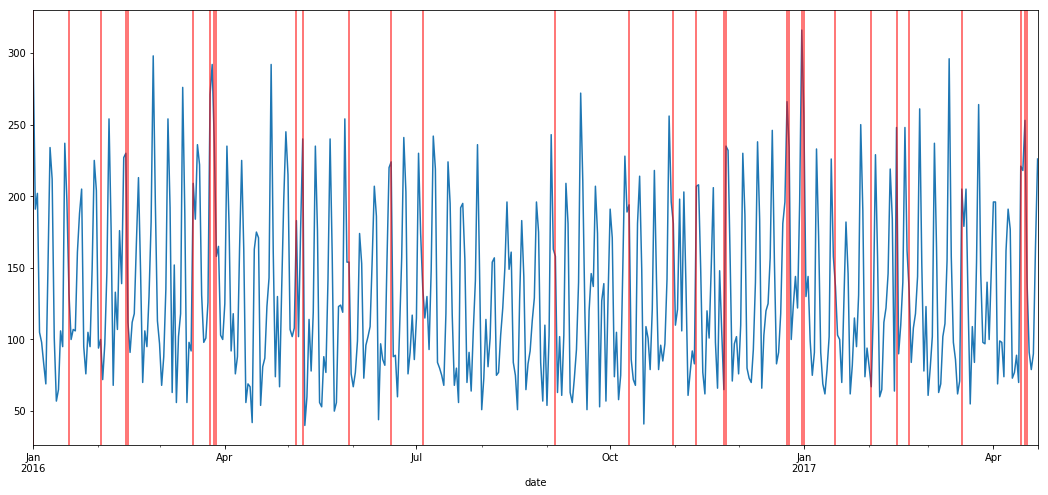

In [15]:
# plot the holidays

ax = df1['total'].plot(figsize = (18,8))

for day in df1.query('holiday==1').index:
  ax.axvline(x=day, color='red', alpha=0.7)

The holidays do not clearly indicate a direct correlation with the number of visitors.
We can also do a ETS Decompositions to take a deeper look at the data.

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [0]:
# Format plot to enhance ETS graph

from pylab import rcParams

rcParams['figure.figsize'] = 12,8

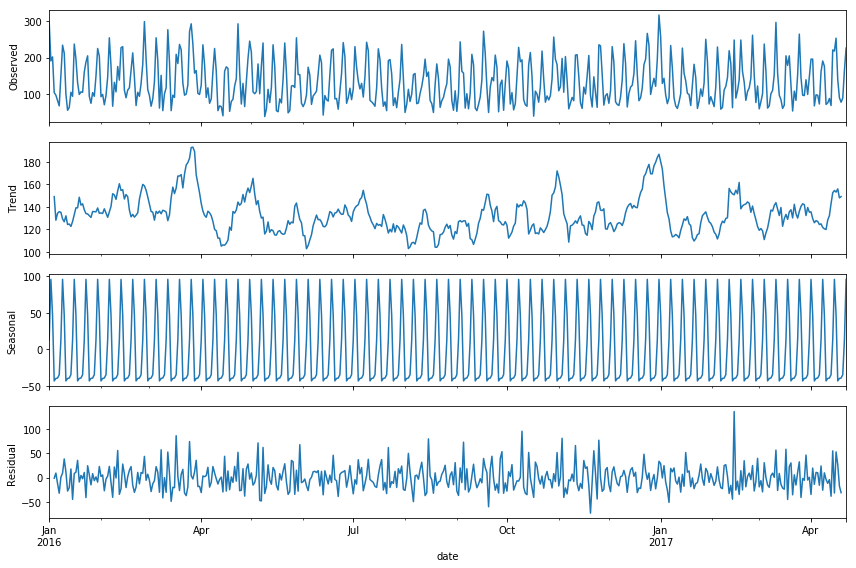

In [18]:
result = seasonal_decompose(df1['total']);
result.plot();

There is strong seasonal component in these data. Let's emhance the graph to have a better view.

> Indented block



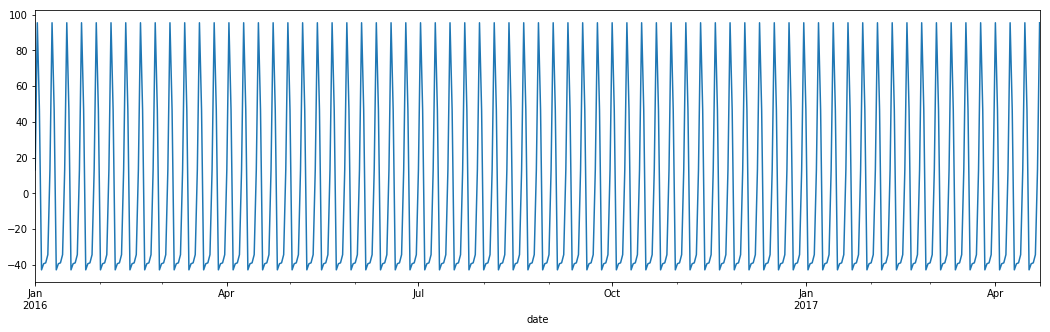

In [19]:
result.seasonal.plot(figsize = (18,5))

## Perform a  SARIMA based model

In [20]:
# split the data into train and test sets -- select 4 weeks for testing purposes
len(df1)


478

In [0]:
train = df1.iloc[:436]

test = df1.iloc[436:]

In [22]:
pip install pmdarima

In [0]:
# run auto_arima
from pmdarima import auto_arima

In [24]:
# Since it is weekly data m=7
auto_arima(df1['total'], seasonal=True, m=7).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2417.721
Date:                           Sat, 13 Jul 2019   AIC                           4845.442
Time:                                   15:47:10   BIC                           4866.290
Sample:                                        0   HQIC                          4853.638
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.5657      4.363      4.714      0.000      12.014      29.117
ar.L1          0.1897      0.045      4.220      0.000       0.102       0.278
ar.S.L7        0.4258      0.037     11.606      0.000       0.354       0.498
ar.S.L14       0.3873      0.036     10.734      0.000       0.317       0.458
sigma2      1427.4032     86.679     16.468      0.000    1257.515    1597.292
===================================================================================
Ljung-Box (Q):                       77.20   Jarque-Bera (JB):                27.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
# create the model -- pass order and X values from the auto_arima summary

model = SARIMAX(train['total'], order=(1,0,0), seasonal_order=(2,0,0,7),
               enforce_invertability=False)

In [0]:
# fit the model
results = model.fit()

In [28]:
# print summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Sat, 13 Jul 2019   AIC                           4457.403
Time:                                   15:47:11   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Predict Values

In [0]:
start = len(train)
end = len(train) + len(test) - 1

In [0]:
predictions = results.predict(start, end).rename('SARIMA Model')

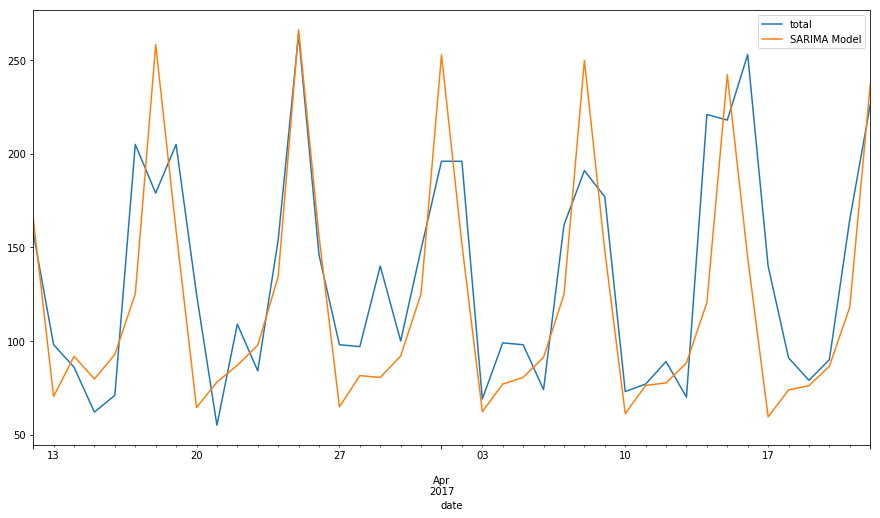

In [31]:
# Plot Predictions
test['total'].plot(legend = True, figsize = (15, 8))
predictions.plot(legend = True)

As we can see, the predictions are not too acurate and fails to capture some peaks on some weeks.
We can overlay the holidays, which have not been taken into account for this model,  to see if that is affecting the predictions.

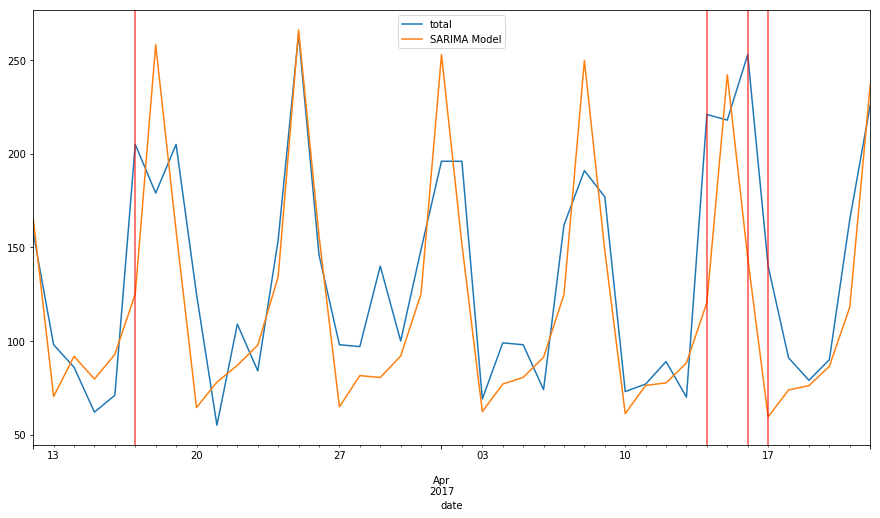

In [32]:
ax = test['total'].plot(legend = True, figsize = (15, 8))
predictions.plot(legend = True);

for day in test.query('holiday==1').index:
  ax.axvline(x=day, color='red', alpha=0.7)

It seems like the holidays are affecting the predictions, especially during the first and fifth week. Adding exogenous variables to the model might improve its performace. 

## Evaluating the Model Using RMSE

In [0]:
from statsmodels.tools.eval_measures import rmse

In [34]:
rmse(test['total'], predictions)

41.26315491179164

## SARIMAX MODEL

When using SARIMAX we need to provide more information for the future dates. We also need to provide the exogenous variables into the future. We cannot, however, predict exogenous variables as we are not able to predict two things at once. 
The data to be used in the SARIMAX model would contain a column for data, exogenous variable and Y_Label. When forecasting for the Y_Label, we provide the date range and the exogenous variable whose future variable must be known (i.e -- if using holidays as an exogenous variable, we know in advance what those holidays are). 

In the graph above, we can see that the model did not perform well around the holidays. Also when evaluating its performance using RMSE-- it returned a value of 41.26. We can add an exogenous variable for the holidays, retrain the model and see if its performance improves. 

In [36]:
# implement model using exogenous variables
# arguments --> y_label = total; exogenous = 'holidays' passed with double brackets as statsmodels
# wants it as a dataframe not a series, seasonal = True, m = '7' because is on a 7 day cycle.

auto_arima(df1['total'], exogenous=df1[['holiday']], seasonal=True, m=7).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2348.662
Date:                           Sat, 13 Jul 2019   AIC                           4709.323
Time:                                   16:17:06   BIC                           4734.341
Sample:                                        0   HQIC                          4719.159
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.5555      4.274      2.704      0.007       3.180      19.931
x1            74.8356      4.545     16.464      0.000      65.927      83.744
ma.L1          0.1782      0.051      3.474      0.001       0.078       0.279
ar.S.L7        0.5059      0.045     11.232      0.000       0.418       0.594
ar.S.L14       0.3843      0.043      8.982      0.000       0.300       0.468
sigma2      1142.0212     80.192     14.241      0.000     984.849    1299.194
===================================================================================
Ljung-Box (Q):                       85.07   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               0.89   Skew:                             0.12
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## TRAIN SARIMAX MODEL

In [0]:
# pass the recommended order and seasonal order values 

model = SARIMAX(train['total'], exog = train[['holiday']], order = (0, 0, 1), seasonal_order=(2, 0, 0, 7),
               enforce_invertibility=False)

In [0]:
# fit model
result = model.fit()

In [42]:
# print summary

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2158.891
Date:                           Sat, 13 Jul 2019   AIC                           4327.783
Time:                                   16:28:16   BIC                           4348.171
Sample:                               01-01-2016   HQIC                          4335.829
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       67.9539      4.278     15.886      0.000      59.570      76.338
ma.L1          0.2057      0.050      4.117      0.000       0.108       0.304
ar.S.L7        0.5146      0.042     12.369      0.000       0.433       0.596
ar.S.L14       0.4598      0.041     11.135      0.000       0.379       0.541
sigma2      1118.0445     73.447     15.223      0.000     974.092    1261.997
===================================================================================
Ljung-Box (Q):                      101.65   Jarque-Bera (JB):                 1.29
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               0.90   Skew:                             0.11
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predict Values

In [0]:
# create start and end range

start = len(train)
end = len(train) + len(test) - 1 

In [0]:
# pass the exog variable as df -- double brackets

predictions = result.predict(start, end, exog = test[['holiday']]).rename('SARIMAX with Exogenous')

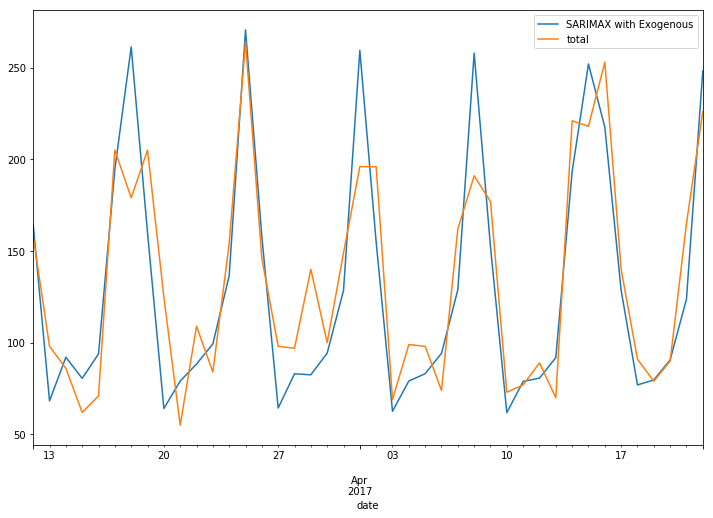

In [46]:
predictions.plot(figsize = (12, 8), legend = True);
test['total'].plot(legend = True)

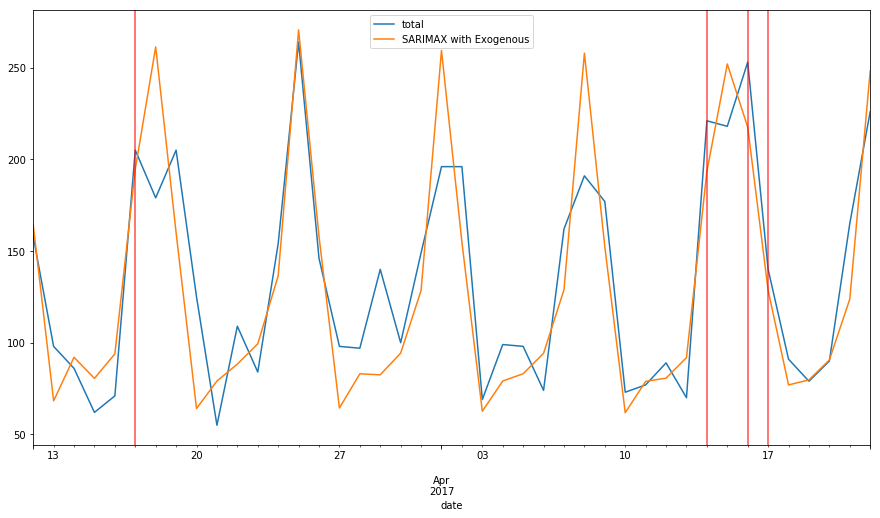

In [47]:
# add holidays to the plot

ax = test['total'].plot(legend = True, figsize = (15, 8))
predictions.plot(legend = True);

for day in test.query('holiday==1').index:
  ax.axvline(x=day, color='red', alpha=0.7)

In [48]:
rmse(test['total'], predictions)

31.092571538751056

### FORECAST

In [0]:
# retrain using all the data

model = SARIMAX(df1['total'], exog=df1[['holiday']],  order = (0, 0, 1), seasonal_order=(2, 0, 0, 7),
               enforce_invertibility=False)

In [50]:
# fit model
result = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Remember that to forecast usinf exogenous values, we must know the values its future value. Since, in this case, those data is known to us, we can extract it from the dataframe adn create a new dataframe.


In [0]:
exog_forecast = df[478:][['holiday']]

In [54]:
exog_forecast

,holiday
date,
2017-04-23,0
2017-04-24,0
2017-04-25,0
2017-04-26,0
2017-04-27,0
2017-04-28,0
2017-04-29,0
2017-04-30,0
2017-05-01,0


In [55]:
forecast_ev = results.predict(len(df1), len(df1) + 38, exog = exog_forecast).rename('SARIMAX FORECAST')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


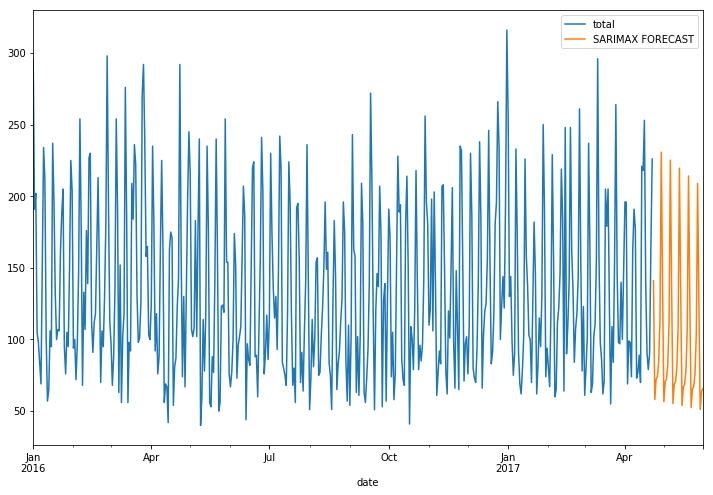

In [59]:
# plot forecast

df1['total'].plot(figsize=(12, 8), legend = True);
forecast_ev.plot(legend = True)

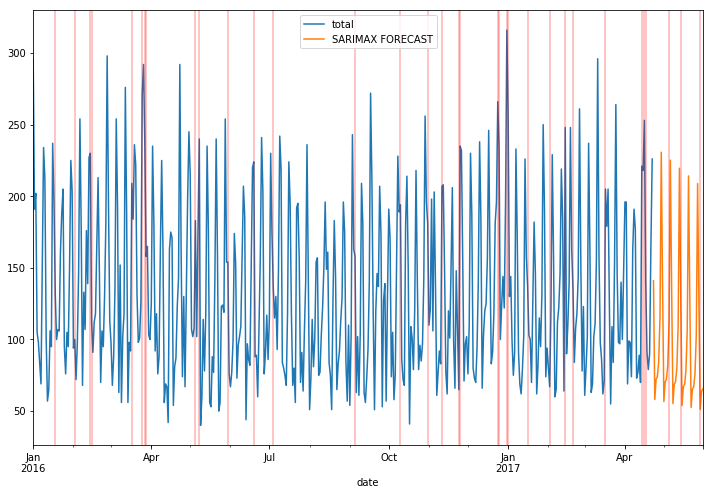

In [62]:
# plot the holidays in red

ax = df1['total'].plot(figsize=(12, 8), legend = True);
forecast_ev.plot(legend = True)

for day in df.query('holiday==1').index:
  ax.axvline(x=day, color='red', alpha=0.3)

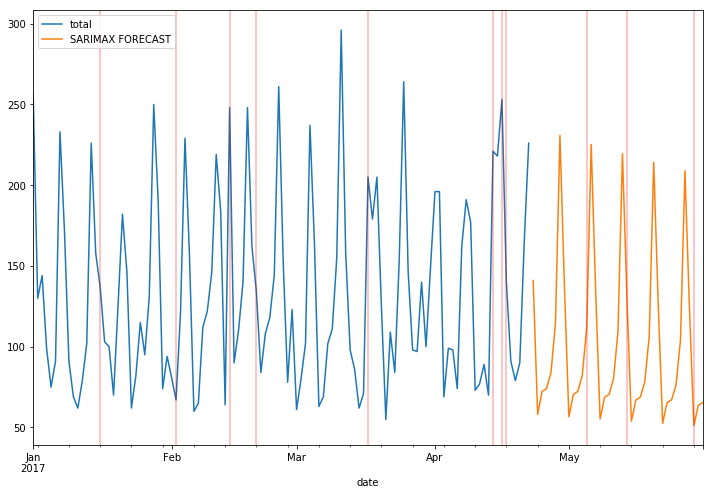

In [63]:
# zoom into the forecasted area

ax = df1['total'].loc['2017-01-01':].plot(figsize=(12, 8), legend = True);
forecast_ev.plot(legend = True)

for day in df.query('holiday==1').index:
  ax.axvline(x=day, color='red', alpha=0.3)